<a href="https://colab.research.google.com/github/nafiul-araf/Image-Segmenation-with-Tensorflow-project-/blob/main/segmentation_U_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import zipfile
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
from matplotlib import pyplot as plt
import seaborn as sns

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.7.0


In [ ]:
class_names=['sky', 'building','column/pole', 'road', 'side walk', 'vegetation', 'traffic light', 'fence', 'vehicle', 
             'pedestrian', 'byciclist', 'void']

In [ ]:
!ls /content/drive/MyDrive/Image_Segmentation/dataset1

annotations_prepped_test   images_prepped_test
annotations_prepped_train  images_prepped_train


In [ ]:
!ls /content/drive/MyDrive/Image_Segmentation/*.py

/content/drive/MyDrive/Image_Segmentation/utility.py


In [ ]:
!cat '/content/drive/MyDrive/Image_Segmentation/utility.py'

import os
import zipfile
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
import seaborn as sns

class_names=['sky', 'building','column/pole', 'road', 'side walk', 'vegetation', 'traffic light', 'fence', 'vehicle', 
             'pedestrian', 'byciclist', 'void']
def map_filename_to_image_and_mask(t_filename, a_filename, height=224, width=224):
  '''
  Preprocesses the dataset by:
    * resizing the input image and label maps
    * normalizing the input image pixels
    * reshaping the label maps from (height, width, 1) to (height, width, 12)

  Args:
    t_filename (string) -- path to the raw input image
    a_filename (string) -- path to the raw annotation (label map) file
    height (int) -- height in pixels to resize to
    width (int) -- width in pixels to resize to

  Returns:
    image (tensor) -- preprocessed image
    annotation (tensor) -- preprocessed annotation
  '''

  # Convert image and mask fi

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Image_Segmentation')

In [ ]:
import utility

sky -- (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)
building -- (1.0, 0.4980392156862745, 0.054901960784313725)
column/pole -- (0.17254901960784313, 0.6274509803921569, 0.17254901960784313)
road -- (0.8392156862745098, 0.15294117647058825, 0.1568627450980392)
side walk -- (0.5803921568627451, 0.403921568627451, 0.7411764705882353)
vegetation -- (0.5490196078431373, 0.33725490196078434, 0.29411764705882354)
traffic light -- (0.8901960784313725, 0.4666666666666667, 0.7607843137254902)
fence -- (0.4980392156862745, 0.4980392156862745, 0.4980392156862745)
vehicle -- (0.7372549019607844, 0.7411764705882353, 0.13333333333333333)
pedestrian -- (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)
byciclist -- (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)
void -- (1.0, 0.4980392156862745, 0.054901960784313725)


In [ ]:
from utility import get_dataset_slice_paths, get_training_dataset, get_validation_dataset

In [ ]:
training_image_paths, training_label_map_paths=get_dataset_slice_paths(r'/content/drive/MyDrive/Image_Segmentation/dataset1/images_prepped_train',
                                                                       r'/content/drive/MyDrive/Image_Segmentation/dataset1/annotations_prepped_train')
validation_image_paths, validation_label_map_paths=get_dataset_slice_paths(r'/content/drive/MyDrive/Image_Segmentation/dataset1/images_prepped_test', 
                                                                           r'/content/drive/MyDrive/Image_Segmentation/dataset1/annotations_prepped_test')

In [ ]:
training_dataset=get_training_dataset(training_image_paths, training_label_map_paths)
validation_dataset=get_validation_dataset(validation_image_paths, validation_label_map_paths)

In [ ]:
from utility import list_show_annotation

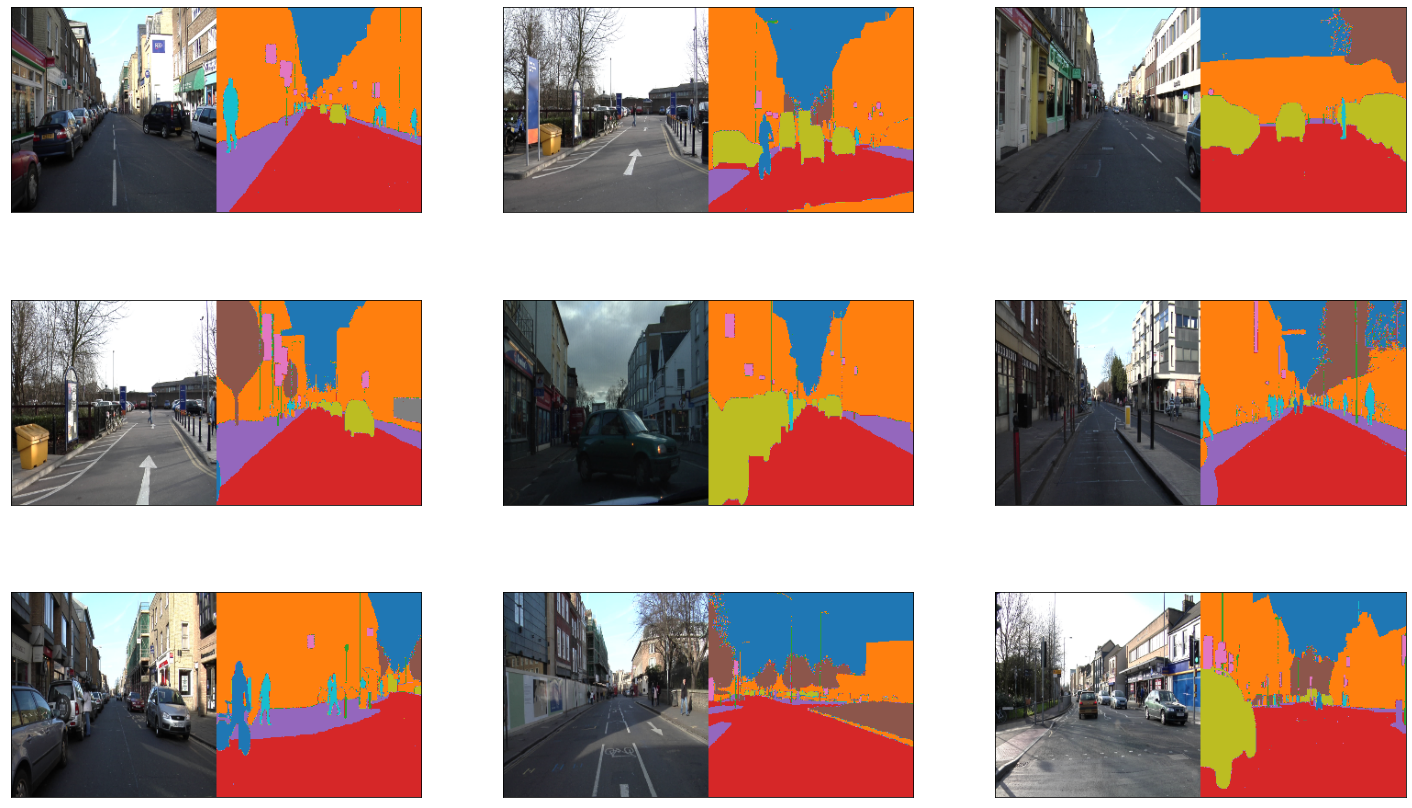

In [ ]:
list_show_annotation(training_dataset)

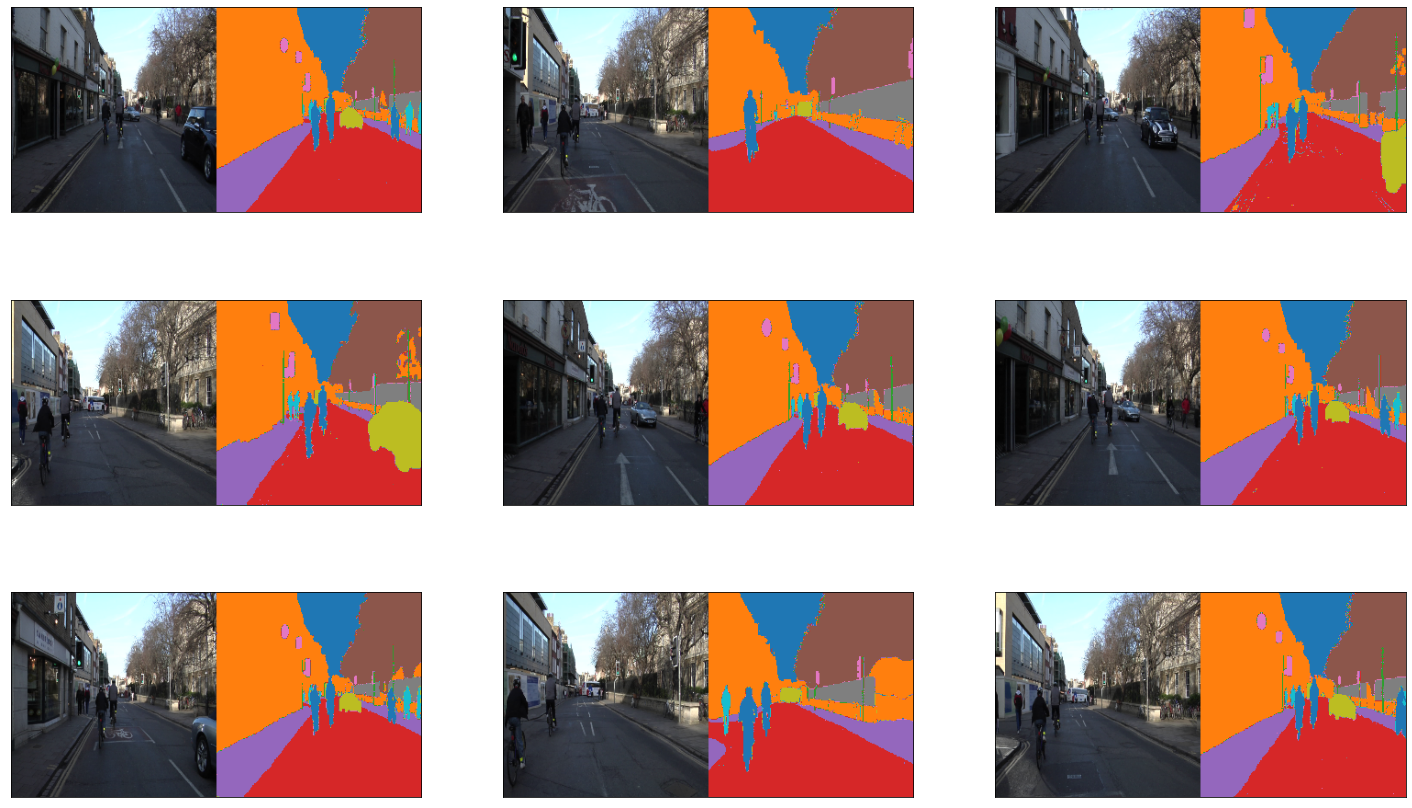

In [ ]:
list_show_annotation(validation_dataset)

In [ ]:
def conv2d_block(inputs, filters, kernel_size=(3, 3)):
    x=inputs
    for i in range(2):
        x=tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, kernel_initializer='he_normal', 
                                padding='same', activation='relu')(x)
    
    return x

In [ ]:
def encoder_block(inputs, filters, kernel_size, pool_size, dropout):
    f=conv2d_block(inputs, filters=filters, kernel_size=kernel_size)
    p=tf.keras.layers.MaxPooling2D(pool_size=pool_size)(f)
    p=tf.keras.layers.Dropout(dropout)(p)
    
    return f, p

In [ ]:
def encoder(inputs):
    f1, p1=encoder_block(inputs, filters=64, kernel_size=(3, 3), pool_size=(2, 2), dropout=0)
    f2, p2=encoder_block(p1, filters=128, kernel_size=(3, 3), pool_size=(2, 2), dropout=0.20)
    f3, p3=encoder_block(p2, filters=256, kernel_size=(3, 3), pool_size=(2, 2), dropout=0)
    f4, p4=encoder_block(p3, filters=512, kernel_size=(3, 3), pool_size=(2, 2), dropout=0.20)
    
    return p4, (f1, f2, f3, f4)

In [ ]:
def bottleneck_block(inputs):
    b=conv2d_block(inputs, filters=1024)
    
    return b

In [ ]:
def decoder_block(inputs, conv_outputs, filters, kernel_size, strides, dropout):
    u=tf.keras.layers.Conv2DTranspose(filters=filters, kernel_size=kernel_size, strides=strides, padding='same')(inputs)
    c=tf.keras.layers.concatenate([u, conv_outputs])
    d=tf.keras.layers.Dropout(dropout)(c)
    l=conv2d_block(d, filters=filters, kernel_size=kernel_size)
    
    return l

In [ ]:
def decoder(inputs, con_outs, output_channels):
    f1, f2, f3, f4=con_outs
    
    d1=decoder_block(inputs, conv_outputs=f4, filters=512, kernel_size=(3, 3), strides=(2, 2), dropout=0.10)
    d2=decoder_block(d1, conv_outputs=f3, filters=256, kernel_size=(3, 3), strides=(2, 2), dropout=0)
    d3=decoder_block(d2, conv_outputs=f2, filters=128, kernel_size=(3, 3), strides=(2, 2), dropout=0)
    d4=decoder_block(d3, conv_outputs=f1, filters=64, kernel_size=(3, 3), strides=(2, 2), dropout=0.10)
    
    outputs=tf.keras.layers.Conv2D(output_channels, kernel_size=(1, 1), activation='softmax')(d4)
    
    return outputs

In [ ]:
def unet_model():
    inputs=tf.keras.layers.Input(shape=(224, 224, 3))
    encoder_output, convs=encoder(inputs)
    bottleneck=bottleneck_block(encoder_output)
    decoder_output=decoder(bottleneck, convs, 12)
    
    model=tf.keras.Model(inputs=inputs, outputs=decoder_output)
    
    return model

model=unet_model()

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 224, 224, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
model.compile(loss='categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), 
              metrics=['accuracy'])

In [ ]:
from glob import glob
data_train=r'/content/drive/MyDrive/Image_Segmentation/dataset1/images_prepped_train/*.png'
data_val=r'/content/drive/MyDrive/Image_Segmentation/dataset1/images_prepped_test/*.png'
print('Total Training Images: {}'.format(len(list(glob(data_train)))))
print('\nTotal Validation Images: {}'.format(len(list(glob(data_val)))))

Total Training Images: 367

Total Validation Images: 101


In [ ]:
train_data=367
val_data=101
BATCH_SIZE=32
history = model.fit(training_dataset, steps_per_epoch=train_data//BATCH_SIZE, validation_data=validation_dataset, 
                    validation_steps=val_data//BATCH_SIZE, epochs=200)

Epoch 1/200
11/11 [==============================] - 59s 2s/step - loss: 5319908352.0000 - accuracy: 0.1925 - val_loss: 2.3889 - val_accuracy: 0.0450
Epoch 2/200
11/11 [==============================] - 27s 1s/step - loss: 2.2497 - accuracy: 0.1845 - val_loss: 2.2120 - val_accuracy: 0.2347
Epoch 3/200
11/11 [==============================] - 15s 1s/step - loss: 2.0255 - accuracy: 0.4069 - val_loss: 1.9808 - val_accuracy: 0.3291
Epoch 4/200
11/11 [==============================] - 15s 1s/step - loss: 1.7769 - accuracy: 0.4343 - val_loss: 1.8972 - val_accuracy: 0.3847
Epoch 5/200
11/11 [==============================] - 14s 1s/step - loss: 1.6989 - accuracy: 0.4481 - val_loss: 1.7766 - val_accuracy: 0.4074
Epoch 6/200
11/11 [==============================] - 14s 1s/step - loss: 1.6748 - accuracy: 0.4490 - val_loss: 1.8595 - val_accuracy: 0.4815
Epoch 7/200
11/11 [==============================] - 14s 1s/step - loss: 1.6463 - accuracy: 0.4621 - val_loss: 1.6844 - val_accuracy: 0.4808
Epoc

In [ ]:
def true_img_segments():
  true_images=[]
  true_segments=[]
  test_data=50
  data=validation_dataset.unbatch()
  data=data.batch(101)

  for image, segment in data.take(1):
    true_images=image
    true_segments=segment
  
  true_segments=true_segments[:test_data, :, :, :]
  true_segments=np.argmax(true_segments, axis=3)

  return true_images, true_segments

true_images, true_segments=true_img_segments()

In [ ]:
predictions=model.predict(validation_dataset, steps=val_data//BATCH_SIZE)
predictions=np.argmax(predictions, axis=3)

In [ ]:
def evaluation_metrics(y_true, y_pred):
  iou_score=[]
  dice_score=[]
  smoothing_factor=0.00001

  for i in range(12):
    y_true_area=np.sum(y_true==i)
    y_pred_area=np.sum(y_pred==i)
    intersect_area=np.sum(y_pred_area*y_true_area)
    combined_area=y_true_area+y_pred_area

    iou=(intersect_area+smoothing_factor)/(combined_area-intersect_area+smoothing_factor)
    iou_score.append(iou)

    dice=2*((intersect_area+smoothing_factor)/(combined_area+smoothing_factor))
    dice_score.append(dice_score)
  
  return iou_score, dice_score

In [ ]:
iou_score, dice_score=evaluation_metrics(true_segments[0], predictions[0])

In [ ]:
from utility import show_predictions

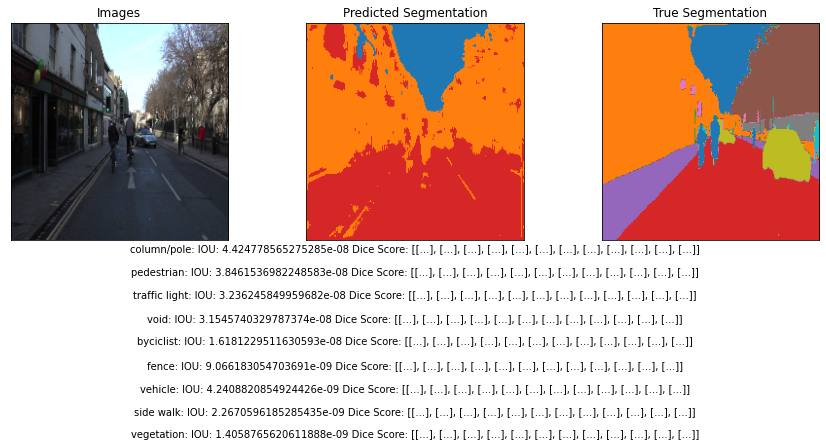

In [ ]:
show_predictions(true_images[0], [predictions[0], true_segments[0]], ['Images', 'Predicted Segmentation', 'True Segmentation'], iou_score, dice_score)

In [ ]:
iou_class, dice_class=evaluation_metrics(true_segments, predictions)

for index, iou in enumerate(iou_class):
  x=' '*(13-len(class_names[index])+2)
  print("{}{}{} ".format(class_names[index], x, iou))

sky            -1.0000061292673719 
building       -1.0000019996582825 
column/pole    6.098304667582447e-10 
road           -1.000001852790857 
side walk      4.596623320297465e-11 
vegetation     2.437888690818719e-11 
traffic light  4.184800801730499e-10 
fence          1.348708611322583e-10 
vehicle        1.788492836766317e-10 
pedestrian     5.678914188381559e-10 
byciclist      1.96105347754377e-10 
void           3.029752165354859e-10 


In [ ]:
for index, dice in enumerate(dice_class):
  x=' '*(13-len(class_names[index])+2)
  print("{}{}{} ".format(class_names[index], x, dice))

sky            [[...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...]] 
building       [[...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...]] 
column/pole    [[...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...]] 
road           [[...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...]] 
side walk      [[...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...]] 
vegetation     [[...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...]] 
traffic light  [[...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...]] 
fence          [[...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...]] 
vehicle        [[...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...]] 
pedestrian     [[...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...]